<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Case-2" data-toc-modified-id="Case-2-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Case 2</a></span></li><li><span><a href="#Background" data-toc-modified-id="Background-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Models-and-training" data-toc-modified-id="Models-and-training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Models and training</a></span></li><li><span><a href="#Results-and-Discussion" data-toc-modified-id="Results-and-Discussion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results and Discussion</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

***

# Case 2
Ville Kajander, Topias Paljakka and Ville Tuomi - Team 8<br>
Last edited: 28.02.2020<br>
Neural Networks for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

***

# Background
The aim of this notebook is to study x-ray images of lungs using convolutional neural network.

***

# Data
The data contained images of healthy lungs and lungs with pneumonia. The data was downloaded from [here](https://data.mendeley.com/datasets/rscbjbr9sj/2). The size of the data was 1.16 GB and it was divided into training set and testing set. The training set had 1349 images of healthy lungs and 3883 images of lungs with pneumonia. The testing set had 234 images of healthy lungs and 390 images of lungs with pneumonia.

In [1]:
%pylab inline
import os, shutil

Populating the interactive namespace from numpy and matplotlib


### Hyper parameters:

In [2]:
proportions = (0.6, 0.2, 0.2) # Proportions between train, validation and test set
batch_size = 16
epochs = 3
target_size = (150,150)
model_dir = './models'
workers = 100 # Maximum number of processes to spin up when using process-based threading
is_saved = True

### Reorganizing the data:

Remove existing directories and make new directories.

In [3]:
train_dir = './train'
valid_dir = './validation'
test_dir = './test'
all_dirs = [train_dir, valid_dir, test_dir]

for d in all_dirs:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.mkdir(d)
    os.mkdir(os.path.join(d,'NORMAL'))
    os.mkdir(os.path.join(d,'PNEUMONIA'))
print(os.listdir(train_dir))

['NORMAL', 'PNEUMONIA']


List all normal and pneumonia image paths in original train and test data.

In [4]:
orig_dir = 'chest_xray/train'
orig_dir2 = 'chest_xray/test'

normal_images = [os.path.join(orig_dir, 'NORMAL', x) for x in os.listdir(os.path.join(orig_dir, 'NORMAL')) if x.endswith('.jpeg')]
normal_images += [os.path.join(orig_dir2, 'NORMAL', x) for x in os.listdir(os.path.join(orig_dir2, 'NORMAL')) if x.endswith('.jpeg')]
pneumonia_images = [os.path.join(orig_dir, 'PNEUMONIA', x) for x in os.listdir(os.path.join(orig_dir, 'PNEUMONIA')) if x.endswith('.jpeg')]
pneumonia_images += [os.path.join(orig_dir2, 'PNEUMONIA', x) for x in os.listdir(os.path.join(orig_dir2, 'PNEUMONIA')) if x.endswith('.jpeg')]


print('Num of normal images:', len(normal_images))
print('Num of pneumonia images:', len(pneumonia_images))

Num of normal images: 1583
Num of pneumonia images: 4273


Randomize the order of the images.

In [5]:
random.seed(1)
random.shuffle(normal_images)
random.shuffle(pneumonia_images)

Copy the images from original directories to new ones and split them into train, validation and test folders.

In [6]:
# Splits given list into multiple lists with given proportions
def data_split(proportions, data):
    for x in np.split(data, np.cumsum(np.rint(np.dot(proportions, len(data))).astype(int))):
         yield x.tolist()

for directory, normals, pneumonias in zip(all_dirs, data_split(proportions, normal_images), 
                                                    data_split(proportions, pneumonia_images)):
    for file in normals + pneumonias:
        shutil.copyfile(file, os.path.join(directory, file.split('\\', 1)[1]))

### Create three image data generators, one for each data set.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dg = ImageDataGenerator(rescale=1./255)

class_mode = 'binary'

train_generator = dg.flow_from_directory(
    train_dir, 
    target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=True)

dev_generator = dg.flow_from_directory(
    valid_dir, 
    target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False)

test_generator = dg.flow_from_directory(
    test_dir, 
    target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False)

Found 3514 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.


Sampling a single image from one of the generators to test it.

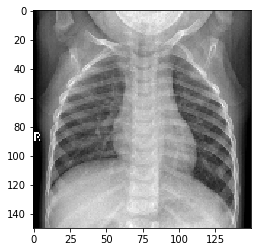

(150, 150, 3)

In [8]:
data_batch = train_generator[0][0]
imshow(data_batch[0])
show()
data_batch[0].shape

***

# Models and training

### Build and train process of our best model:

Layer selection

In [9]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

model = Sequential(name = 'Beast')
model.add(Conv2D(32, (3,3), padding='same', input_shape=data_batch[0].shape))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(32, (3,3)))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

Compiling

In [10]:
from tensorflow.keras.metrics import SensitivityAtSpecificity

model.compile(loss='binary_crossentropy', metrics=[SensitivityAtSpecificity(0.9)])

Calculating the maximum steps per epoch and validation steps given sample size and batch size.

In [11]:
steps_per_epoch = int(train_generator.samples / batch_size)
validation_steps = int(dev_generator.samples / batch_size)

print('Maximum number of steps per epoch:', steps_per_epoch)
print('Maximum number of validation steps:', validation_steps)

Maximum number of steps per epoch: 219
Maximum number of validation steps: 73


Custom callback for simplified verbose output while training.

In [12]:
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output

class OneCallback(Callback):
    def __init__(self, epochs, steps_per_epoch, validation_steps):
        self.epochs = epochs
        self.steps_per_epoch = steps_per_epoch
        self.validation_steps = validation_steps        
        print('Starting...')
    
    def print_out(self):
        text = f'Epoch {self.epoch}/{self.epochs}'
        text += f'\nTraining steps: {self.train}/{self.steps_per_epoch}'
        text += f'\nValidation steps: {self.test}/{self.validation_steps}'        
        clear_output(wait=True)
        print(text)
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch + 1
        self.train = 0
        self.test = 0
        self.print_out()
    
    def on_train_batch_begin(self, batch, logs=None):
        self.train = batch + 1
        self.print_out()
        
    def on_test_batch_begin(self, batch, logs=None):
        self.test = batch + 1
        self.print_out()

Training

In [13]:
%%time
history = model.fit(train_generator,
                      workers=workers,
                      steps_per_epoch=steps_per_epoch,
                      verbose=0,
                      epochs=epochs,
                      validation_data=dev_generator,
                      validation_steps=validation_steps,
                      callbacks=[OneCallback(epochs, steps_per_epoch, validation_steps)])

Epoch 3/3
Training steps: 219/219
Validation steps: 73/73
Wall time: 10min 21s


Training history / metrics

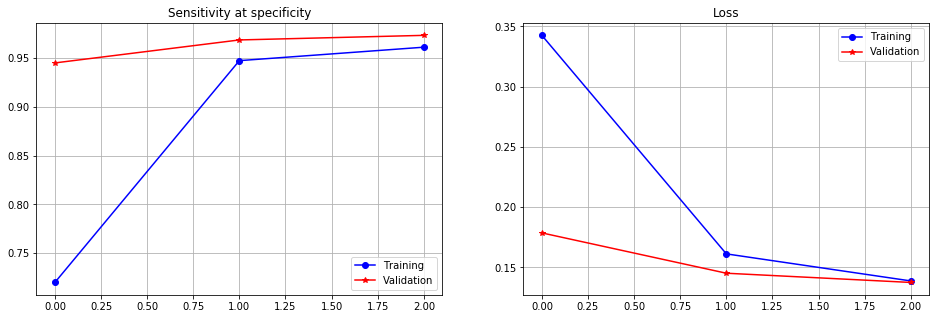

In [14]:
fig, axes = subplots(1,2,figsize=(16,5))

epochs_range = range(len(history.history['loss']))

#print(history.history.keys())

axes[0].plot(epochs_range, history.history['sensitivity_at_specificity'], 'bo-', label='Training')
axes[0].plot(epochs_range, history.history['val_sensitivity_at_specificity'], 'r*-', label='Validation')
axes[0].set_title('Sensitivity at specificity')
axes[0].grid()
axes[0].legend()

axes[1].plot(epochs_range, history.history['loss'], 'bo-', label='Training')
axes[1].plot(epochs_range, history.history['val_loss'], 'r*-', label='Validation')
axes[1].set_title('Loss')
axes[1].grid()
axes[1].legend()

show()

Saving the model for later.

In [15]:
if is_saved:
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)

    count = len(os.listdir(model_dir)) + 1

    new_file_path = f'{model_dir}/model_{count:03d}_epochs_{epochs}.h5'
    print(new_file_path)

    model.save(new_file_path)

./models/model_019_epochs_3.h5


### Load models:

A few of our previously build and trained models are loaded from memory.

In [16]:
models = [model]
models.append(load_model(f'{model_dir}/Trio_50.h5'))
models.append(load_model(f'{model_dir}/Zigzag_50.h5'))

all_colors = ['red', 'green', 'blue']

### Summary of each model:

In [17]:
for m in models:
    m.summary()
    print()

Model: "Beast"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10368)             0     

***

# Results and Discussion

### Testing and comparing results:

True values from test data.

In [18]:
labels = test_generator.classes

Values predicted from the test data by each model and the time it took.

In [19]:
import time

pnc = [] # list of tuples containing predictions, names, and colors

for i, m in enumerate(models):
    start = time.time()
    pred = m.predict(test_generator, workers=workers)
    end = time.time()
    pnc.append((pred, m.name, all_colors[i]))
    print(f'{m.name} took {end - start:.0f} seconds')

Beast took 32 seconds
Trio took 16 seconds
Zigzag took 66 seconds


>Time it takes to do predictions is mostly determined by the amount of parameters the model has (and the computing power).

Plot true and predicted values. 0 = normal and 1 = pneumonia.

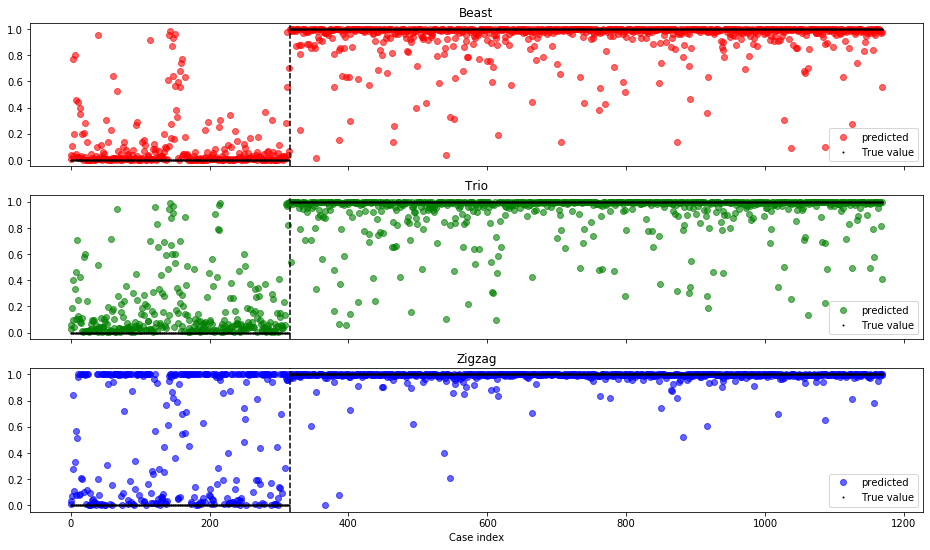

In [20]:
i = next(x[0] for x in enumerate(labels) if x[1]) #index where label turns to 1

fig, axes = subplots(len(pnc), sharex=True, figsize=(16, 3 * len(pnc)))

for n, (pred, name, color) in enumerate(pnc):
    axes[n].plot(pred, 'o', c=color, lw=2, alpha=0.6, label='predicted')
    axes[n].plot(labels, 'o', c='black', ms=1, label='True value')
    axes[n].axvline(i, c='black', ls='--', lw=1.5)
    axes[n].set_title(name)
    axes[n].legend(loc='lower right')
    
xlabel('Case index')
show()

>**Beast**'s predictions are following true values quite closely.
>
>**Trio** isn't quite as sure about everything.
>
>**Zigzag** is predicting negative outcome, possible because samples consist mostly of those. 

### Confusion matrices

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

from IPython.display import Markdown

mask = '<br>' # newline
mask += '%s =' # name
mask += '$' # latex begin
mask += '\\begin{bmatrix}' # matrix begin
mask += '%d & %d\\\\ %d & %d'
mask += '\\end{bmatrix}' # matrix end
mask += '$' # latex end
mask += '<br>' # newline

s = ''
for pred, name, color in pnc:
    cm = confusion_matrix(labels, pred > 0.5).T
    s += mask % (name, *cm.flatten())
display(Markdown(s))   

<br>Beast =$\begin{bmatrix}293 & 24\\ 23 & 830\end{bmatrix}$<br><br>Trio =$\begin{bmatrix}278 & 42\\ 38 & 812\end{bmatrix}$<br><br>Zigzag =$\begin{bmatrix}142 & 4\\ 174 & 850\end{bmatrix}$<br>

>**Beast** is achieving smallest false negatives and false positives overall.
>
>**Trio** is suprisingly good aswell.
>
>**Zigzag** seems to have a preference towards the negative outcome.

### Classification reports

In [22]:
for pred, name, color in pnc:
    cr = classification_report(labels, pred > 0.5, target_names=['Normal (0)','Pneumonia (1)'])
    print(f'{name}:')
    print(cr)

Beast:
               precision    recall  f1-score   support

   Normal (0)       0.92      0.93      0.93       316
Pneumonia (1)       0.97      0.97      0.97       854

     accuracy                           0.96      1170
    macro avg       0.95      0.95      0.95      1170
 weighted avg       0.96      0.96      0.96      1170

Trio:
               precision    recall  f1-score   support

   Normal (0)       0.87      0.88      0.87       316
Pneumonia (1)       0.96      0.95      0.95       854

     accuracy                           0.93      1170
    macro avg       0.91      0.92      0.91      1170
 weighted avg       0.93      0.93      0.93      1170

Zigzag:
               precision    recall  f1-score   support

   Normal (0)       0.97      0.45      0.61       316
Pneumonia (1)       0.83      1.00      0.91       854

     accuracy                           0.85      1170
    macro avg       0.90      0.72      0.76      1170
 weighted avg       0.87      0.85  

>**Beast** has over 90% precision, recall and f1-score in all classes.
>
>**Trio** doesn't quite reach same level.
>
>**Zigzag** is good in some while worse in others.

### ROC curve (Receiver Operating Characteristic)

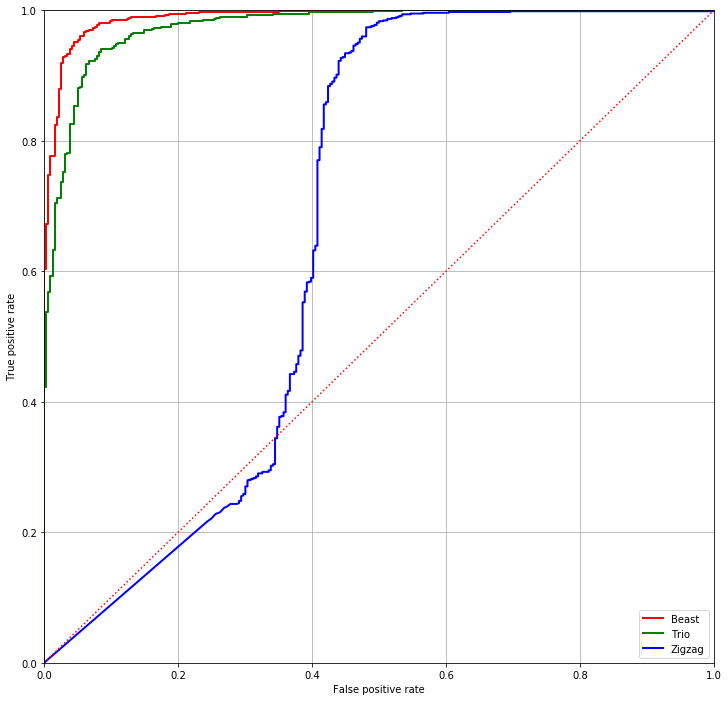

In [23]:
figure(figsize=(12,12))
for pred, name, color in pnc:
    fpr, tpr, tresholds = roc_curve(labels, pred, pos_label=1)
    plot(fpr, tpr, c=color, label=name, lw=2)    
plot([0, 1], [0, 1], 'r:')
xlabel('False positive rate')
ylabel('True positive rate')
xlim([0,1])
ylim([0,1])
legend()
grid()
show()

>**Beast** and **Trio** are quite accurate at predicting the whether or not patient has pneumonia.
>
>**Zigzag** falls quite a bit short of the other two.

***

# Conclusions

### Building and training models: 

* The larger models with more layers and more filters seemed to be worse than smaller ones with considerably less. Althought the sample size may have an effect on this. 

* Models where same filter size was used repeatedly seemed to work great while changing filter size often made models worse. 

* Accending the filter size seemed to be better than the opposite.  

* The best patch size seemed to be between 10-16 and the more epochs meant more overfitting especially on the larger models. 

* We tried rotating and flipping pictures in the image data generator and putting in a dropout layer, both of which seemed to help with overfitting but in the end we got a better model without them.

**More conclusions..?** 